In [1]:
import glob
import numpy as np
import pandas as pd
from collections import defaultdict

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preview'] = True
plt.rc('font', family='serif', serif=['Times'])
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-a02471d74a87>:18: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preview'] = True


In [2]:
!which latex

/Library/TeX/texbin/latex


In [3]:
model2name = {
    "m3p": "M$^3$P",
    "uc2": "UC$^2$",
    "ctrl_muniter": "mUNITER",
    "ctrl_xuniter": "xUNITER",
    "ctrl_lxmert": "LXMERT",
    "ctrl_uniter": "UNITER",
    "ctrl_vilbert": "ViLBERT",
    "ctrl_visualbert": "VisualBERT",
    "ctrl_vl-bert": "VL-BERT",
}

In [4]:
lang2name = {
    'en': 'ENG',
    'ar': 'ARB',
    'bn': 'BEN',
    'bg': 'BUL',
    'da': 'DAN',
    'et': 'EST',
    'de': 'DEU',
    'el': 'ELL',
    'fr': 'FRA',
    'id': 'IND',
    'ja': 'JPN',
    'ko': 'KOR',
    'zh': 'CMN',
    'pt': 'POR',
    'ru': 'RUS',
    'es': 'SPA',
    'sw': 'SWA',
    'ta': 'TAM',
    'tr': 'TUR',
    'vi': 'VIE',
}
lang2ix = {l: ix for ix, l in enumerate(lang2name.keys())}

## Wikipedia size

In [5]:
art_df = pd.read_csv("wiki_sizes.csv")
art_df.sort_values('articles', inplace=True)
art_df.head()

,language,articles
16,sw,69061
2,bn,116906
17,ta,143851
7,el,204784
5,et,224525


In [6]:
lang2size = {l: art_df[(art_df['language'] == l)]['articles'].values[0] for l in lang2name.keys()}

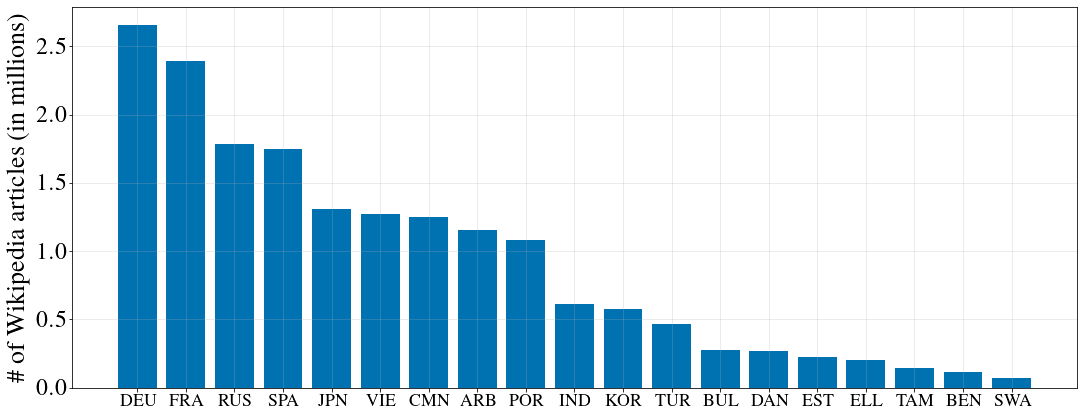

In [36]:
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

f, ax = plt.subplots(1, 1, figsize=(18,7))

xs = art_df['language'][::-1][1:]
ys = art_df['articles'][::-1][1:]
ax.bar(xs, ys/1e6, color=colors[5])

ax.grid(alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xticklabels([lang2name[l] for l in xs], fontsize=18)
ax.set_ylabel('\# of Wikipedia articles (in millions)', fontsize=26)

f.savefig("wiki_sizes.pdf", bbox_anchor="tight")

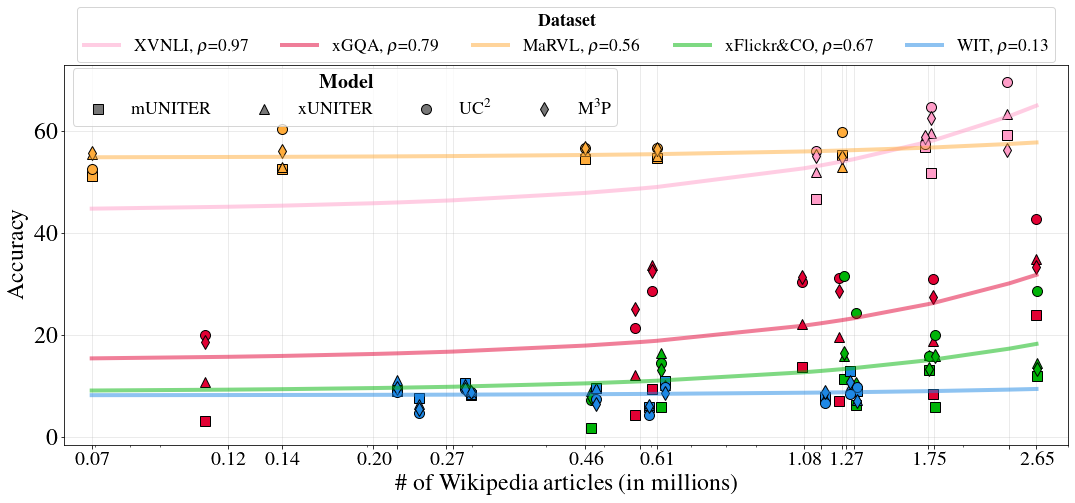

In [15]:
f, ax = plt.subplots(1, 1, figsize=(18,7))

colors = ['#ff9dc8', '#e20134', '#ffac3b', '#00b408', '#1E88E5']
markers = ['X', 's', '^', 'o', 'd']

legend_elements = []
for m, n in zip(markers[1:], ['ctrl_muniter', 'ctrl_xuniter', 'uc2', 'm3p']):
    legend_elements.append(Line2D([0], [0], marker=m, color='#777777', label=model2name[n], 
                                  markerfacecolor="#777777", markeredgecolor='k', markersize=10, linewidth=0))
lgd2 = ax.legend(handles=legend_elements, title="\\textbf{Model}", loc='upper left', bbox_to_anchor=(0, 1.015, 0, 0),
                 ncol=4, fontsize=18, title_fontsize=20)

model2avgs = defaultdict(list)
for it, dset in enumerate(['XVNLI', 'xGQA', 'MaRVL', 'xFlickrCO', 'WIT']):
    j = 0.01 * (-2+it)
    try:
        dset_0 = pd.read_csv(f"../results/{dset.lower()}/{dset}_0.csv")[:4]
    except:
        dset_0 = pd.read_csv(f"../results/{dset.lower()}/{dset}_ir_0.csv")[:4]
    for im, m in enumerate(['ctrl_muniter', 'ctrl_xuniter', 'uc2', 'm3p']):
        for lang in dset_0.columns[2:-1]:
            val = dset_0[(dset_0['model'] == m)][lang]
            x = lang2size[lang]/1e6
            ax.plot(x+j, val, marker=markers[im+1], markersize=10, markeredgecolor='k', linewidth=3, color=colors[it])

for it, dset in enumerate(['XVNLI', 'xGQA', 'MaRVL', 'xFlickrCO', 'WIT']):
    x2avg = {}
    xs = []
    vals = []
    try:
        dset_0 = pd.read_csv(f"{dset.lower()}/{dset}_0.csv")[:4]
    except:
        dset_0 = pd.read_csv(f"{dset.lower()}/{dset}_ir_0.csv")[:4]
    for lang in dset_0.columns[2:-1]:
        v = dset_0[lang].values
        x2avg[lang2size[lang]/1e6] = np.mean(v)
        vals.extend(v)
        xs.extend([lang2size[lang]/1e6]*len(v))
    p = np.polyfit(xs, vals, 1, rcond=None, full=False, w=None, cov=False)
    ys = [np.poly1d(p)(x) for x in sorted(xs)]
    corr = pearsonr([x2avg[x] for x in sorted(x2avg.keys())], [x for x in sorted(x2avg.keys())])

    ys = [np.poly1d(p)(x) for x in art_df['articles'].values[:-1]/1e6]
    xs = art_df['articles'].values[:-1]/1e6
    dset = "xFlickr\&CO" if dset == "xFlickrCO" else dset
    ax.plot(xs, ys, linewidth=4, color=colors[it], alpha=0.5, label=f"{dset}, $\\rho$=%.2f" % corr[0])

ax.grid(alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.minorticks_off()
ax.set_xlim(0.062, 3)
ax.set_xscale('log')
ax.set_xticks(art_df['articles'].values[:-1]/1e6)
nums = ['%.2f' % v for v in art_df['articles'].values[:-1]/1e6]  
nums2 = ['0.07','0.12','0.14','0.20','','0.27','','0.46','','0.61','1.08','','','1.27','','1.75','','','2.65']
ax.set_xticklabels(['%.2f' % float(v) if v != '' else '' for v in nums2 ], fontsize=20)
ax.set_xlabel('\# of Wikipedia articles (in millions)', fontsize=24)
ax.set_ylabel('Accuracy', fontsize=24)
ax.legend(title='\\textbf{Dataset}', loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.175, 0, 0), fontsize=17.5, title_fontsize=18)

plt.gca().add_artist(lgd2)
f.savefig("wiki_zero-shot-scores.svg", bbox_extra_artists=(lgd2,), bbox_anchor="tight")

## Typology

In [8]:
import sys
sys.path.append("../tools/lang2vec")
import lang2vec.lang2vec as l2v  # see [https://github.com/antonisa/lang2vec] for installation
from scipy import stats
import pandas as pd

def uriel_distance_vec(languages):
    """
    Adapted from langrank [https://github.com/neulab/langrank/blob/master/langrank.py]
    """
    geographic = l2v.geographic_distance(languages)
    genetic = l2v.genetic_distance(languages)
    inventory = l2v.inventory_distance(languages)
    syntactic = l2v.syntactic_distance(languages)
    phonological = l2v.phonological_distance(languages)
    featural = l2v.featural_distance(languages)
    uriel_features = {n:v for n, v in zip(['genetic', 'syntactic', 'featural', 'phonological', 'inventory', 'geographic'], 
                                          [genetic, syntactic, featural, phonological, inventory, geographic])}
    return uriel_features


uriel = uriel_distance_vec([v.lower() for v in lang2name.values()])

In [43]:
# dset-URIEL correlations
dset2vals = {}
dset2dists = {}
dist2tasks_r = np.zeros((5, len(uriel)))
dist2tasks_p = np.zeros((5, len(uriel)))
for it, dset in enumerate(['XVNLI', 'xGQA', 'MaRVL', 'xFlickrCO', 'WIT']):
    try:
        dset_0 = pd.read_csv(f"{dset.lower()}/{dset}_0.csv")[:4]
    except:
        dset_0 = pd.read_csv(f"{dset.lower()}/{dset}_ir_0.csv")[:4]
    en_v = dset_0['en'].values
    dist2vals = defaultdict(list)
    diffs = []
    for lang in dset_0.columns[2:-1]:
        val = dset_0[lang].values
        diffs.extend(val)
        for k, v in uriel.items():
            dist2vals[k].extend([v[0,lang2ix[lang]]] * len(val))
    dset2dists[dset] = []
    for ix, k in enumerate(uriel.keys()):
        pearson_r, pearsonp = stats.pearsonr(diffs, dist2vals[k])
        dist2tasks_r[it][ix] = pearson_r
        dist2tasks_p[it][ix] = pearsonp
        dset2vals[dset] = diffs
        dset2dists[dset].append(dist2vals[k])

for it, dset in enumerate(['XVNLI', 'xGQA', 'MaRVL', 'xFlickrCO', 'WIT']):
    print(dset, end=" ")
    for ix, k in enumerate(uriel.keys()):
        print(f"& %.2f (%.3f)" % (dist2tasks_r[it][ix], dist2tasks_p[it][ix]), end=" ")
    print("\\\\")

XVNLI & -0.60 (0.013) & -0.52 (0.038) & -0.60 (0.013) & -0.44 (0.087) & -0.59 (0.017) & -0.45 (0.077) \\
xGQA & -0.41 (0.032) & -0.56 (0.002) & -0.46 (0.013) & -0.19 (0.345) & -0.25 (0.194) & -0.25 (0.196) \\
MaRVL & nan (nan) & 0.09 (0.694) & -0.09 (0.716) & -0.26 (0.271) & -0.21 (0.378) & -0.34 (0.142) \\
xFlickr & -0.23 (0.238) & -0.37 (0.051) & -0.21 (0.279) & 0.02 (0.921) & 0.08 (0.674) & 0.06 (0.775) \\
WIT & -0.36 (0.023) & -0.31 (0.052) & -0.23 (0.157) & -0.35 (0.026) & -0.23 (0.146) & 0.10 (0.521) \\


XVNLI 0.5217375413335972
xGQA 0.5580889382266925
MaRVL -0.09387233282578422
xFlickr 0.37233727825867274
WIT 0.3097611565415168


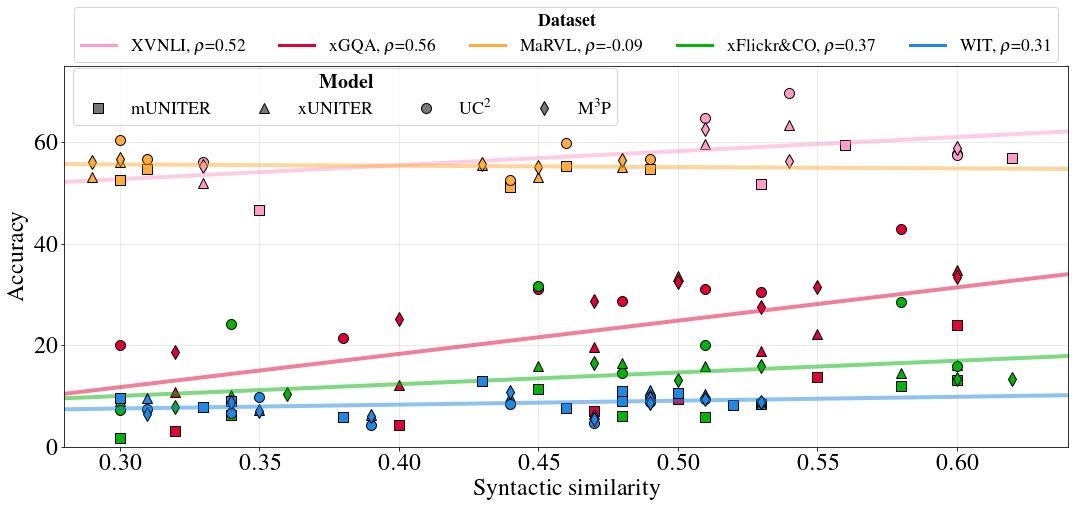

In [96]:
f, ax = plt.subplots(1, 1, figsize=(18,7))

xmin, xmax = (0.28, 0.64)
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 75)

colors = ['#ff9dc8', '#e20134', '#ffac3b', '#00b408', '#1E88E5']
markers = ['X', 's', '^', 'o', 'd']

amodels = ['ctrl_muniter', 'ctrl_xuniter', 'uc2', 'm3p']

legend_elements = []
for m, n in zip(markers[1:], ['ctrl_muniter', 'ctrl_xuniter', 'uc2', 'm3p']):
    legend_elements.append(Line2D([0], [0], marker=m, color='#777777', label=model2name[n], 
                                  markerfacecolor="#777777", markeredgecolor='k', markersize=10, linewidth=0))
lgd2 = ax.legend(handles=legend_elements, title="\\textbf{Model}", loc='upper left', bbox_to_anchor=(0, 1.02, 0, 0),
                 ncol=4, fontsize=18, title_fontsize=20)

dset2sims = {}
for dset, ll in dset2dists.items():
    dset2sims[dset] = []
    for l in ll:
        dset2sims[dset].append([1-e for e in l])

pearsons = []
for it, (dset, ys) in enumerate(dset2vals.items()):
    xs = dset2sims[dset][1]
    for im in range(4):
        j = np.random.randint(1,3,1)[0]/100
        j *= (np.random.rand() > 0.5)
        vals = [x for ix, x in enumerate(ys) if ix % 4 == im]
        diss = [x+j for ix, x in enumerate(xs) if ix % 4 == im]
        ax.plot(diss, vals, ls='', marker=markers[im+1], markersize=10, markeredgecolor='k', color=colors[it])
    pearson_r, pearson_p = stats.pearsonr(xs, ys)
    pearsons.append(pearson_r)
    print(dset, pearson_r)
    
    p = np.polyfit(xs, ys, 1, rcond=None, full=False, w=None, cov=False)
    ys = [np.poly1d(p)(x) for x in np.arange(xmin, xmax+0.1, 0.1)]
    ax.plot(np.arange(xmin, xmax+0.1, 0.1), ys, linewidth=4, color=colors[it], alpha=0.5)


legend_elements = [
    Line2D([0], [0], color=colors[0], label='XVNLI, $\\rho$=%.2f' % pearsons[0], linewidth=3, markersize=0, linestyle='-'),
    Line2D([0], [0], color=colors[1], label='xGQA, $\\rho$=%.2f' % pearsons[1], linewidth=3, markersize=0, linestyle='-'),
    Line2D([0], [0], color=colors[2], label='MaRVL, $\\rho$=%.2f' % pearsons[2], linewidth=3, markersize=0, linestyle='-'),
    Line2D([0], [0], color=colors[3], label='xFlickr\&CO, $\\rho$=%.2f' % pearsons[3], linewidth=3, markersize=0, linestyle='-'),
    Line2D([0], [0], color=colors[4], label='WIT, $\\rho$=%.2f' % pearsons[4], linewidth=3, markersize=0, linestyle='-'),
]
ax.legend(handles=legend_elements, title='\\textbf{Dataset}', loc='upper center', 
          ncol=5, bbox_to_anchor=(0.5, 1.179, 0, 0), fontsize=17.5, title_fontsize=18)

ax.grid(alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.minorticks_off()
ax.set_xlabel('Syntactic similarity', fontsize=24)
ax.set_ylabel('Accuracy', fontsize=24)

plt.gca().add_artist(lgd2)
f.savefig("syntactic-sim_zero-shot-scores.pdf", bbox_extra_artists=(lgd2,), bbox_anchor="tight")